<a href="https://colab.research.google.com/github/ivan890617/Cluster-practice/blob/main/LSTM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Read the data & Data preprocessing

In [4]:
data = pd.read_csv("/content/result.csv")
data["Datetime"] = pd.to_datetime(data["Datetime"])
data_sort = data.sort_values(by='Datetime')
data_sort = pd.DataFrame(data_sort,columns=['Datetime','AEP_MW','sub_label'])
data_sort

,Datetime,AEP_MW,sub_label
0,2004-10-01 01:00:00,12379.0,2
1,2004-10-01 02:00:00,11935.0,2
2,2004-10-01 03:00:00,11692.0,1
3,2004-10-01 04:00:00,11597.0,1
4,2004-10-01 05:00:00,11681.0,1
...,...,...,...
121268,2018-08-02 20:00:00,17673.0,7
121269,2018-08-02 21:00:00,17303.0,6
121270,2018-08-02 22:00:00,17001.0,6
121271,2018-08-02 23:00:00,15964.0,5


set the label from 1-9 to 0-8 

In [5]:
data_sort["sub_label"] = data_sort["sub_label"] -1
data_sort

,Datetime,AEP_MW,sub_label
0,2004-10-01 01:00:00,12379.0,1
1,2004-10-01 02:00:00,11935.0,1
2,2004-10-01 03:00:00,11692.0,0
3,2004-10-01 04:00:00,11597.0,0
4,2004-10-01 05:00:00,11681.0,0
...,...,...,...
121268,2018-08-02 20:00:00,17673.0,6
121269,2018-08-02 21:00:00,17303.0,5
121270,2018-08-02 22:00:00,17001.0,5
121271,2018-08-02 23:00:00,15964.0,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


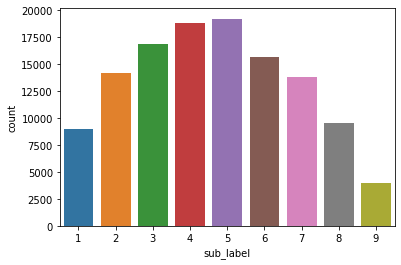

In [6]:
sns.countplot(data['sub_label'])

Convert to data that can be used by the model

Give a sliding window,in other words,the model would not only read the instant data,but also read the data in the past.

In [7]:
def sliding_windows(data,label, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = label.iloc[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

normalize the data

In [ ]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_sort[['AEP_MW']])

divide the data into training set and test set

In [ ]:
seq_length = 4
x, y = sliding_windows(training_data,data_sort['sub_label'] ,seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))
trainY = trainY.long()

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [8]:
print(dataX.shape)
print(dataY.shape)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

torch.Size([121268, 4, 1])
torch.Size([121268])
torch.Size([81249, 4, 1])
torch.Size([81249])
torch.Size([40019, 4, 1])
torch.Size([40019])
tensor([0, 1, 2,  ..., 8, 8, 8])


# **Define the LSTM model**

In [13]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size # 設定越多代表能記住的特徵越多
        self.seq_length = seq_length

        # LSTM layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.3)

         # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):                  # x's shape (batch_size, 序列长度, 序列中每个数据的长度)
        out, _ = self.lstm(x)              # out's shape (batch_size, 序列长度, hidden_dim)
        out = out[:, -1, :]                # 中间的序列长度取-1，表示取序列中的最后一个数据，这个数据长度为hidden_dim，
                                           # 得到的out的shape为(batch_size, hidden_dim)
        out = self.fc(out)             # 经过线性层后，out的shape为(batch_size, n_class)
        return out


# **Start training**

In [14]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1      #input feature size
hidden_size = 64     #hidden layer cell size
num_layers = 2      #hidden layer

num_classes = 9   #output size

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    # 1 將data傳入model進行forward propagation
    # (put data into model and start forward propagation)
    outputs = lstm(trainX)
    # 2 清空前一次的gradient
    # (clean gradient last time)
    optimizer.zero_grad()
    # 3 obtain the loss function
    loss = criterion(outputs, trainY)
    # 4 根據loss進行back propagation，計算gradient
    # (start back propagation based on loss,and calculate gradient)
    loss.backward()
    # 5 做gradient descent
    # (start gradient descent)
    optimizer.step()
    if epoch % 25 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 2.18505
Epoch: 25, loss: 2.12009
Epoch: 50, loss: 2.07151
Epoch: 75, loss: 1.76095
Epoch: 100, loss: 1.66613
Epoch: 125, loss: 1.59962
Epoch: 150, loss: 1.48248
Epoch: 175, loss: 1.31475
Epoch: 200, loss: 1.19478
Epoch: 225, loss: 1.11875
Epoch: 250, loss: 1.07515
Epoch: 275, loss: 1.02793
Epoch: 300, loss: 0.99541
Epoch: 325, loss: 0.96879
Epoch: 350, loss: 0.94062
Epoch: 375, loss: 0.91647
Epoch: 400, loss: 0.89563
Epoch: 425, loss: 0.86762
Epoch: 450, loss: 0.84086
Epoch: 475, loss: 0.81578
Epoch: 500, loss: 0.79926
Epoch: 525, loss: 0.77389
Epoch: 550, loss: 0.75213
Epoch: 575, loss: 0.74181
Epoch: 600, loss: 0.71824
Epoch: 625, loss: 0.70853
Epoch: 650, loss: 0.69127
Epoch: 675, loss: 0.67741
Epoch: 700, loss: 0.66422
Epoch: 725, loss: 0.65371
Epoch: 750, loss: 0.64298
Epoch: 775, loss: 0.63321
Epoch: 800, loss: 0.62508
Epoch: 825, loss: 0.63210
Epoch: 850, loss: 0.60815
Epoch: 875, loss: 0.59721
Epoch: 900, loss: 0.59968
Epoch: 925, loss: 0.58610
Epoch: 950, loss:

# **Start Predict**

[8 7 7 ... 5 5 5]


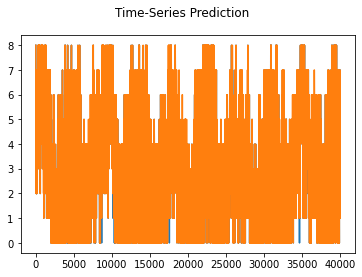

In [16]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
data_predict = np.argmax(data_predict, axis=1)
print(data_predict)

data_predict = pd.DataFrame(data_predict)
data_predict

dataY_plot = testY.data.numpy()

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(testY,data_predict))
print(classification_report(testY,data_predict))
print(accuracy_score(testY,data_predict))

[[4000  726    0    0    0    0    0    0    0]
 [ 195 4846  693    0    1    0    0    0    0]
 [   0  353 5377 1195    4    0    0    0    0]
 [   0    0  525 5306  865    2    0    0    0]
 [   0    1    0  429 4081  535    0    0    0]
 [   0    0    0    0  508 3233  381    0    0]
 [   0    0    0    0    0  382 3007  216    0]
 [   0    0    0    0    0    0  287 2096   64]
 [   0    0    0    0    0    0    0  126  585]]
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      4726
         1.0       0.82      0.84      0.83      5735
         2.0       0.82      0.78      0.80      6929
         3.0       0.77      0.79      0.78      6698
         4.0       0.75      0.81      0.78      5046
         5.0       0.78      0.78      0.78      4122
         6.0       0.82      0.83      0.83      3605
         7.0       0.86      0.86      0.86      2447
         8.0       0.90      0.82      0.86       711

    accuracy             